In [1]:
!pip install transformers #snorkel better_profanity textblob
!pip install small-text[transformers]==1.0.0b3

     |████████████████████████████████| 4.0 MB 10.1 MB/s 
     |████████████████████████████████| 77 kB 5.6 MB/s 
     |████████████████████████████████| 596 kB 31.1 MB/s 
     |████████████████████████████████| 895 kB 53.8 MB/s 
     |████████████████████████████████| 6.6 MB 57.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 122 kB 9.9 MB/s 


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
from nltk.corpus import stopwords
import nltk
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import tensorflow_hub as hub
from gensim.models import KeyedVectors
from transformers import BertTokenizer
from transformers import BertTokenizerFast, BertForSequenceClassification
from transformers import BertConfig
from transformers import BertModel, get_linear_schedule_with_warmup
from transformers import RobertaTokenizer
from transformers import RobertaConfig
from transformers import RobertaModel
from torch.utils.data import Dataset, DataLoader
import torch
from torch import nn
from sklearn.metrics import accuracy_score,f1_score
from sklearn.metrics import confusion_matrix
from collections import Counter
import spacy
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from keras.preprocessing import sequence
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
from torch.optim import AdamW
from collections import defaultdict
from scipy.stats import entropy
import matplotlib.pyplot as plt
import seaborn as sn

In [3]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
#load pretrained word2vec
#word2vec = KeyedVectors.load_word2vec_format("/content/gdrive/MyDrive/CS6471/GoogleNews-vectors-negative300.bin.gz", binary=True)

# Data Preprocessing


In [6]:
#load data
df = pd.read_csv('/content/gdrive/MyDrive/CS6471/reddit_comments.csv')

In [7]:
#discretize data according to this split
split = [
         [-1,-0.34],
         [-0.34,0.34],
         [0.34,1]
         ]

def discretize(val,split):
  if(split[0][0]<=val<split[0][1]):
    return 0
  elif(split[1][0]<=val<split[1][1]):
    return 1
  else:
    return 2


df['class'] = df['offensiveness_score'].apply(lambda x:discretize(x,split))

In [8]:
#clean text
whitelist = set('abcdefghijklmnopqrstuvwxyz ABCDEFGHIJKLMNOPQRSTUVWXYZ1234567890')
def cleaner(x):
    x = x.replace("\n"," ")
    x = "".join(filter(whitelist.__contains__, x))
    x = x.lower()
    x = x.strip()
    return x
df["clean_text"] = df["txt"].apply(cleaner)


# Baseline Data Split

In [9]:
#split df into train and test
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
y_train = list(df_train['class'])
y_test = list(df_test['class'])

# Logistic Regression, SVM, Random Forest with Tfidf, Count Vectorizer

In [ ]:
#tokenize data with tfidf
tfidf = TfidfVectorizer(stop_words=stop_words, max_features=1000)
countvec = CountVectorizer(stop_words = stop_words, max_features = 1000)
x_train = tfidf.fit_transform(df_train["clean_text"])
x_test = tfidf.transform(df_test["clean_text"])

x_train_countvec = countvec.fit_transform(df_train["clean_text"])
x_test_countvec = countvec.transform(df_test["clean_text"])


----Count Vectorizer----
Accuracy 0.7689210950080515
F1-score 0.6214982506728941
[[ 45 148   0]
 [ 61 812  29]
 [  3  46  98]]
----TFIDF----
Accuracy 0.782608695652174
F1-score 0.5691494521430437
[[ 18 175   0]
 [ 21 873   8]
 [  1  65  81]]


[Text(0.5, 1.0, 'Confusion Matrix Log Reg Reddit')]

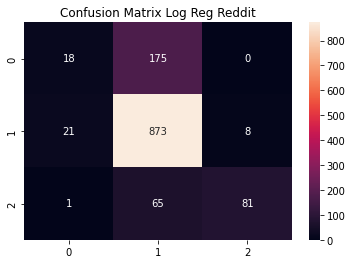

In [ ]:
#Logistic regression classifying toxic and non toxic comments

log_model = LogisticRegression()
log_model.fit(x_train_countvec, y_train)
pred_log_model = log_model.predict(x_test_countvec)

print("----Count Vectorizer----")
print("Accuracy {}".format(accuracy_score(y_test, pred_log_model)))
print("F1-score {}".format(f1_score(y_test, pred_log_model,average = "macro")))
print(confusion_matrix(y_test,pred_log_model))

log_model = LogisticRegression()
log_model.fit(x_train, y_train)
pred_log_model = log_model.predict(x_test)

print("----TFIDF----")
print("Accuracy {}".format(accuracy_score(y_test, pred_log_model)))
print("F1-score {}".format(f1_score(y_test, pred_log_model,average = "macro")))
print(confusion_matrix(y_test,pred_log_model))

sn.heatmap(confusion_matrix(y_test,pred_log_model),annot = True,fmt = "g").set(title = "Confusion Matrix Log Reg Reddit")


----Count Vectorizer----
Accuracy 0.789049919484702
F1-score 0.5329316640584246
[[  5 188   0]
 [  1 899   2]
 [  1  70  76]]
----TFIDF----
Accuracy 0.7954911433172303
F1-score 0.5790083145854453
[[ 19 174   0]
 [  9 890   3]
 [  0  68  79]]


[Text(0.5, 1.0, 'Confusion Matrix SVM Reddit')]

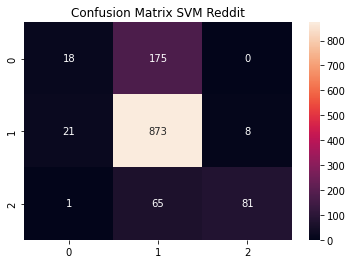

In [ ]:
#SVM
svm_model = SVC()
svm_model.fit(x_train_countvec, y_train)
pred_svm_model = svm_model.predict(x_test_countvec)

print("----Count Vectorizer----")
print("Accuracy {}".format(accuracy_score(y_test, pred_svm_model)))
print("F1-score {}".format(f1_score(y_test, pred_svm_model,average = "macro")))
print(confusion_matrix(y_test,pred_svm_model))

svm_model = SVC()
svm_model.fit(x_train, y_train)
pred_svm_model = svm_model.predict(x_test)

print("----TFIDF----")
print("Accuracy {}".format(accuracy_score(y_test, pred_svm_model)))
print("F1-score {}".format(f1_score(y_test, pred_svm_model,average = "macro")))
print(confusion_matrix(y_test,pred_svm_model))

sn.heatmap(confusion_matrix(y_test,pred_log_model),annot = True,fmt = "g").set(title = "Confusion Matrix SVM Reddit")


----Count Vectorizer----
Accuracy 0.7906602254428341
F1-score 0.6721400571327898
[[ 66 126   1]
 [ 72 819  11]
 [  5  45  97]]
----TFIDF----
Accuracy 0.8011272141706924
F1-score 0.668834417437877


[Text(0.5, 1.0, 'Confusion Matrix Random Forest Reddit')]

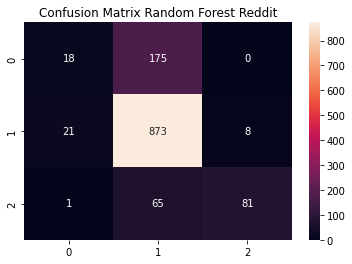

In [ ]:
rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(x_train_countvec, y_train)
pred_rf_model = rf_model.predict(x_test_countvec)

print("----Count Vectorizer----")
print("Accuracy {}".format(accuracy_score(y_test, pred_rf_model)))
print("F1-score {}".format(f1_score(y_test, pred_rf_model,average = "macro")))
print(confusion_matrix(y_test,pred_rf_model))

rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(x_train, y_train)
pred_rf_model = rf_model.predict(x_test)

print("----TFIDF----")
print("Accuracy {}".format(accuracy_score(y_test, pred_rf_model)))
print("F1-score {}".format(f1_score(y_test, pred_rf_model,average = "macro")))
confusion_matrix(y_test,pred_rf_model)

sn.heatmap(confusion_matrix(y_test,pred_log_model),annot = True,fmt = "g").set(title = "Confusion Matrix Random Forest Reddit")


# LSTM 

In [ ]:
vocab_size = 8000
max_len = 896

In [ ]:
#tokenization
tokenizer = Tokenizer(num_words = vocab_size)
tokenizer.fit_on_texts(df_train['clean_text'].values)

In [ ]:
train_encoding = sequence.pad_sequences(tokenizer.texts_to_sequences(df_train['clean_text'].values),maxlen = max_len)
test_encoding = sequence.pad_sequences(tokenizer.texts_to_sequences(df_test['clean_text'].values),maxlen = max_len)


In [ ]:
class comment_dataset(Dataset):
  def __init__(self,X,Y):
    self.X = X
    self.y = Y
  
  def __len__(self):
    return len(self.y)

  def __getitem__(self,idx):
    return torch.tensor(self.X[idx]),self.y[idx]

In [ ]:
batch_size = 32

train_dataset = comment_dataset(train_encoding,df_train['class'].values)
test_dataset = comment_dataset(test_encoding,df_test['class'].values)
train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_dataset, batch_size=batch_size)

In [ ]:
class LSTM_fixed_len(torch.nn.Module) :
    def __init__(self, vocab_size, embedding_dim, hidden_dim) :
        super().__init__()
    
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 5)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = self.embeddings(x)
        x = self.dropout(x)
        lstm_out, (ht, ct) = self.lstm(x)
        return self.linear(ht[-1])

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_fixed =  LSTM_fixed_len(vocab_size, 50, 50).to(device)

In [ ]:
def train_model(model, epochs=10, lr=0.001):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    for i in range(epochs):
        model.train()
        sum_loss = 0.0
        total = 0
        for x, y in tqdm(train_dl):
            x = x.to(device)
            y = y.to(device)
            y_pred = model(x)
            y = y.cpu()
            y_pred = y_pred.cpu()
            loss = F.cross_entropy(y_pred, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            sum_loss += loss.item()*y.shape[0]
            total += y.shape[0]
        test_loss, test_acc, test_rmse = validation_metrics(model, test_dl)
        print("train loss %.3f, test loss %.3f, test accuracy %.3f, and test rmse %.3f" %(sum_loss/total, test_loss, test_acc, test_rmse))

p = []
t = []
def validation_metrics (model, test_dl):
    model.eval()
    correct = 0
    total = 0
    sum_loss = 0.0
    sum_rmse = 0.0
    for x, y in test_dl:
        x = x.to(device)
        y = y.to(device)
        y_hat = model(x)
        y_hat = y_hat.cpu()
        y = y.cpu()
        loss = F.cross_entropy(y_hat, y)
        pred = torch.max(y_hat, 1)[1]
        p.append(pred)
        t.append(y)
        correct += (pred == y).float().sum()
        total += y.shape[0]
        sum_loss += loss.item()*y.shape[0]
        sum_rmse += np.sqrt(mean_squared_error(pred, y.unsqueeze(-1)))*y.shape[0]
    return sum_loss/total, correct/total, sum_rmse/total

In [ ]:
train_model(model_fixed, epochs=1, lr=0.01)

100%|██████████| 156/156 [00:05<00:00, 26.12it/s]


train loss 0.155, test loss 0.864, test accuracy 0.777, and test rmse 0.485


array([[ 78, 109,   6],
       [ 86, 793,  23],
       [  2,  51,  94]])

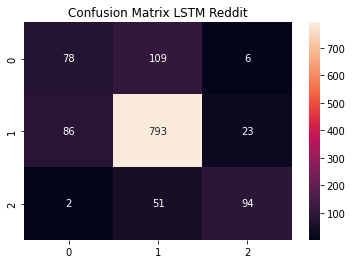

In [ ]:
p = [p_.cpu() for p_ in p]
t = [t_.cpu() for t_ in t]
sn.heatmap(confusion_matrix(torch.cat(t).tolist(),torch.cat(p).tolist()),annot = True,fmt = "g").set(title = "Confusion Matrix LSTM Reddit")

confusion_matrix(torch.cat(t).tolist(),torch.cat(p).tolist())

# Pretrained Models BERT

In [ ]:
class RedditDataset(Dataset):

  def __init__(self, text, targets, tokenizer, max_len):
    self.text = text
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.text)
  
  def __getitem__(self, item):
    comment = self.text[item]
    target = self.targets[item]

    encoding_body = self.tokenizer.encode_plus(
      comment,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
      truncation = True
    )


    return {
      'comment_body': comment,
      'input_ids': encoding_body['input_ids'].flatten(),
      'attention_mask': encoding_body['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = RedditDataset(
    text=df.clean_text.to_numpy(),
    targets=df['class'].to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=2
  )

In [ ]:
MAX_LEN = 512
BATCH_SIZE = 16
PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
train_dataloader = create_data_loader(df_train, tokenizer = tokenizer, max_len = MAX_LEN, batch_size=BATCH_SIZE)
test_dataloader = create_data_loader(df_test, tokenizer = tokenizer, max_len = MAX_LEN, batch_size=BATCH_SIZE)

In [ ]:
nb_labels = 3
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class RedditClassifier(nn.Module):
  def __init__(self,nb_labels):
    super(RedditClassifier,self).__init__()
    self.bert_body = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    #self.bert_body = RobertaModel.from_pretrained(PRE_TRAINED_MODEL_NAME)


    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert_body.config.hidden_size, nb_labels)


  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert_body(
        input_ids = input_ids,
        attention_mask = attention_mask,
        return_dict = False
    )

    output = self.drop(pooled_output)
    return self.out(output)

In [ ]:
EPOCHS = 1
model = RedditClassifier(nb_labels)
model.to(device)
optimizer = AdamW(model.parameters(), lr=2e-5)
total_steps = len(train_dataloader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in tqdm(data_loader,position = 0,leave = True):
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)


    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
p = []
t = []
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)



      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask,

      )
      x = outputs
      _, preds = torch.max(outputs, dim=1)
      p.append(preds)
      t.append(targets)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_dataloader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  test_acc, test_loss = eval_model(
    model,
    test_dataloader,
    loss_fn, 
    device, 
    len(df_test)
  )

  print(f'Test loss {test_loss} accuracy {test_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['test_acc'].append(test_acc)
  history['test_loss'].append(test_loss)

  if test_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = test_acc

Epoch 1/1
----------


  0%|          | 0/311 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length

Train loss 0.5975326837738227 accuracy 0.7601691502215062



/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input s

Test loss 0.4216579240866197 accuracy 0.8260869565217391



In [ ]:
p = [p_.cpu() for p_ in p]
t = [t_.cpu() for t_ in t]
confusion_matrix(torch.cat(t).tolist(),torch.cat(p).tolist())

[Text(0.5, 1.0, 'Confusion Matrix BERT Reddit')]

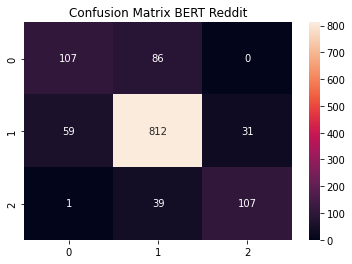

In [ ]:
conf = np.array([[107,86,0],[59,812,31],[1,39,107]])
sn.heatmap(conf,annot = True,fmt = "g").set(title = "Confusion Matrix BERT Reddit")


# Small-Text Active Learning Entropy

In [10]:
from small_text.integrations.transformers.datasets import TransformersDataset

In [11]:
from transformers import AutoTokenizer

transformer_model_name = 'bert-base-uncased'

tokenizer = AutoTokenizer.from_pretrained(
    transformer_model_name
)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [12]:
def get_transformers_dataset(tokenizer, data, labels, max_length=60):

    data_out = []

    for i, doc in enumerate(data):
        encoded_dict = tokenizer.encode_plus(
            doc,
            add_special_tokens=True,
            padding='max_length',
            max_length= 512,
            return_attention_mask=True,
            return_tensors='pt',
            truncation='longest_first'
        )

        data_out.append((encoded_dict['input_ids'], encoded_dict['attention_mask'], labels[i]))

    return TransformersDataset(data_out)

In [13]:
train = get_transformers_dataset(tokenizer,df_train['clean_text'].values,df_train['class'].values)
test = get_transformers_dataset(tokenizer,df_test['clean_text'].values,df_test['class'].values)

In [14]:
from small_text.active_learner import PoolBasedActiveLearner

from small_text.initialization import random_initialization_balanced
from small_text.integrations.transformers import TransformerModelArguments
from small_text.integrations.transformers.classifiers.factories import TransformerBasedClassificationFactory
from small_text.query_strategies import PredictionEntropy
from small_text.integrations.transformers import TransformerModelArguments

def initialize_active_learner(active_learner, y_train):

    indices_initial = random_initialization_balanced(y_train, n_samples=20)
    active_learner.initialize_data(indices_initial, y_train[indices_initial])

    return indices_initial

num_classes = 3
transformer_model = TransformerModelArguments(transformer_model_name)
clf_factory = TransformerBasedClassificationFactory(transformer_model, 
                                                    num_classes, 
                                                    kwargs=dict({'device': 'cuda', 
                                                                 'mini_batch_size': 12,
                                                                 'class_weight': 'balanced'
                                                                }))
query_strategy = PredictionEntropy()
active_learner = PoolBasedActiveLearner(clf_factory, query_strategy, train)
indices_labeled = initialize_active_learner(active_learner, train.y)

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

In [ ]:
from sklearn.metrics import accuracy_score


num_queries = 11


def evaluate(active_learner, train, test):
    y_pred = active_learner.classifier.predict(train)
    y_pred_test = active_learner.classifier.predict(test)
    
    test_acc = accuracy_score(y_pred_test, test.y)

    print('Train accuracy: {:.2f}'.format(accuracy_score(y_pred, train.y)))
    print('Test accuracy: {:.2f}'.format(test_acc))
    
    return test_acc


results = []
results.append(evaluate(active_learner, train[indices_labeled], test))
indices_used = []

    
for i in range(num_queries):
    # ...where each iteration consists of labelling 20 samples
    indices_queried = active_learner.query(num_samples=500)
    indices_used.append(indices_queried)


    # Simulate user interaction here. Replace this for real-world usage.
    y = train.y[indices_queried]

    # Return the labels for the current query to the active learner.
    active_learner.update(y)

    indices_labeled = np.concatenate([indices_queried, indices_labeled])
    
    print('---------------')
    print(f'Iteration #{i} ({len(indices_labeled)} samples)')
    results.append(evaluate(active_learner, train[indices_labeled], test))

Train accuracy: 0.55
Test accuracy: 0.15
---------------
Iteration #0 (520 samples)
Train accuracy: 0.89
Test accuracy: 0.77
---------------
Iteration #1 (1020 samples)
Train accuracy: 0.85
Test accuracy: 0.78
---------------
Iteration #2 (1520 samples)
Train accuracy: 0.91
Test accuracy: 0.81
---------------
Iteration #3 (2020 samples)
Train accuracy: 0.60
Test accuracy: 0.61
---------------
Iteration #4 (2520 samples)
Train accuracy: 0.72
Test accuracy: 0.69
---------------
Iteration #5 (3020 samples)
Train accuracy: 0.81
Test accuracy: 0.77
---------------
Iteration #6 (3520 samples)
Train accuracy: 0.60
Test accuracy: 0.65
---------------
Iteration #7 (4020 samples)
Train accuracy: 0.64
Test accuracy: 0.65


# Small Text Active Learning Least Confident

In [ ]:
from small_text.integrations.transformers.datasets import TransformersDataset

In [ ]:
from transformers import AutoTokenizer

transformer_model_name = 'bert-base-uncased'

tokenizer = AutoTokenizer.from_pretrained(
    transformer_model_name
)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [ ]:
def get_transformers_dataset(tokenizer, data, labels, max_length=60):

    data_out = []

    for i, doc in enumerate(data):
        encoded_dict = tokenizer.encode_plus(
            doc,
            add_special_tokens=True,
            padding='max_length',
            max_length= 512,
            return_attention_mask=True,
            return_tensors='pt',
            truncation='longest_first'
        )

        data_out.append((encoded_dict['input_ids'], encoded_dict['attention_mask'], labels[i]))

    return TransformersDataset(data_out)

In [ ]:
train = get_transformers_dataset(tokenizer,df_train['clean_text'].values,df_train['class'].values)
test = get_transformers_dataset(tokenizer,df_test['clean_text'].values,df_test['class'].values)

In [ ]:
from small_text.active_learner import PoolBasedActiveLearner

from small_text.initialization import random_initialization_balanced
from small_text.integrations.transformers import TransformerModelArguments
from small_text.integrations.transformers.classifiers.factories import TransformerBasedClassificationFactory
from small_text.query_strategies import LeastConfidence
from small_text.integrations.transformers import TransformerModelArguments

def initialize_active_learner(active_learner, y_train):

    indices_initial = random_initialization_balanced(y_train, n_samples=20)
    active_learner.initialize_data(indices_initial, y_train[indices_initial])

    return indices_initial

num_classes = 3
transformer_model = TransformerModelArguments(transformer_model_name)
clf_factory = TransformerBasedClassificationFactory(transformer_model, 
                                                    num_classes, 
                                                    kwargs=dict({'device': 'cuda', 
                                                                 'mini_batch_size': 14,
                                                                 'class_weight': 'balanced'
                                                                }))
query_strategy = LeastConfidence()
active_learner = PoolBasedActiveLearner(clf_factory, query_strategy, train)
indices_labeled = initialize_active_learner(active_learner, train.y)

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

In [ ]:
from sklearn.metrics import accuracy_score


num_queries = 11


def evaluate(active_learner, train, test):
    y_pred = active_learner.classifier.predict(train)
    y_pred_test = active_learner.classifier.predict(test)
    
    test_acc = accuracy_score(y_pred_test, test.y)

    print('Train accuracy: {:.2f}'.format(accuracy_score(y_pred, train.y)))
    print('Test accuracy: {:.2f}'.format(test_acc))
    
    return test_acc


results = []
results.append(evaluate(active_learner, train[indices_labeled], test))
indices_used = []

    
for i in range(num_queries):
    # ...where each iteration consists of labelling 20 samples
    indices_queried = active_learner.query(num_samples=490)
    indices_used.append(indices_queried)


    # Simulate user interaction here. Replace this for real-world usage.
    y = train.y[indices_queried]

    # Return the labels for the current query to the active learner.
    active_learner.update(y)

    indices_labeled = np.concatenate([indices_queried, indices_labeled])
    
    print('---------------') 
    print(f'Iteration #{i} ({len(indices_labeled)} samples)')
    results.append(evaluate(active_learner, train[indices_labeled], test))

Train accuracy: 0.60
Test accuracy: 0.27
---------------
Iteration #0 (510 samples)
Train accuracy: 0.57
Test accuracy: 0.43
---------------
Iteration #1 (1000 samples)
Train accuracy: 0.88
Test accuracy: 0.73
---------------
Iteration #2 (1490 samples)
Train accuracy: 0.73
Test accuracy: 0.70
---------------
Iteration #3 (1980 samples)
Train accuracy: 0.72
Test accuracy: 0.68
---------------
Iteration #4 (2470 samples)
Train accuracy: 0.18
Test accuracy: 0.24
---------------
Iteration #5 (2960 samples)
Train accuracy: 0.40
Test accuracy: 0.47
---------------
Iteration #6 (3450 samples)
Train accuracy: 0.77
Test accuracy: 0.72
---------------
Iteration #7 (3940 samples)
Train accuracy: 0.50
Test accuracy: 0.52
---------------
Iteration #8 (4430 samples)
Train accuracy: 0.64
Test accuracy: 0.65
---------------
Iteration #9 (4920 samples)
Train accuracy: 0.68
Test accuracy: 0.68


PoolExhaustedException: ignored